# Data preview via STAC

Adapted from [the excellent Clay Foundation docs](https://clay-foundation.github.io/model/tutorials/clay-v1-wall-to-wall.html)

## Dependencies

In [7]:
%%capture
%pip install geopandas pystac_client stackstac matplotlib rasterio shapely

In [9]:
import math
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import geopandas as gpd
import pystac_client
import stackstac
from matplotlib import pyplot as plt
from rasterio.enums import Resampling
from shapely import Point

## Set globals
Grab the centroid location from [this Mapbox helper site](https://labs.mapbox.com/location-helper/#3/40.78/-73.97) if needed.

In [25]:
# Note the order when pasting :)
lon, lat = 20.69872, -6.44722

# Date range over the past year unless specified
if 'start' not in locals() or 'end' not in locals():
    # Get the current date
    current_date = datetime.now()
    
    # Get the date one year ago
    one_year_ago = current_date - timedelta(days=365)
    
    # Format both dates as YYYY-MM-DD
    start = one_year_ago.strftime('%Y-%m-%d')
    end = current_date.strftime('%Y-%m-%d')

## Check data availability
Using Element 84's STAC catalog

In [26]:
STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 1e-5, lat - 1e-5, lon + 1e-5, lat + 1e-5),
    max_items=100,
    query={"eo:cloud_cover": {"lt": 80}},
)

all_items = search.item_collection()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

Found 48 items


## Set a bounding box around the centroid

In [27]:
# Extract coordinate system from first item
epsg = items[0].properties["proj:epsg"]

# Convert point of interest into the image projection
# (assumes all images are in the same projection)
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(lon, lat)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

# Create bounds in projection
size = 256
gsd = 10
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

## Retrieve the data

In [28]:
# Retrieve the pixel values, for the bounding box in
# the target projection. In this example we use only
# the RGB and NIR bands.
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype="int64",
    rescale=False,
    fill_value=0,
    assets=["blue", "green", "red", "nir"],
    resampling=Resampling.nearest,
)

print(stack)

stack = stack.compute()

<xarray.DataArray 'stackstac-441f647e223b8120e6cabd7069ba1ec6' (time: 48,
                                                                band: 4,
                                                                y: 256, x: 256)> Size: 101MB
dask.array<fetch_raster_window, shape=(48, 4, 256, 256), dtype=int64, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 384B 2023-...
    id                                       (time) <U24 5kB 'S2A_34MDT_20230...
  * band                                     (band) <U5 80B 'blue' ... 'nir'
  * x                                        (x) float64 2kB 4.654e+05 ... 4....
  * y                                        (y) float64 2kB 9.289e+06 ... 9....
    view:sun_azimuth                         (time) float64 384B 73.64 ... 61.98
    ...                                       ...
    gsd                                      int64 8B 10
    title                  

## Preview the imagery samples

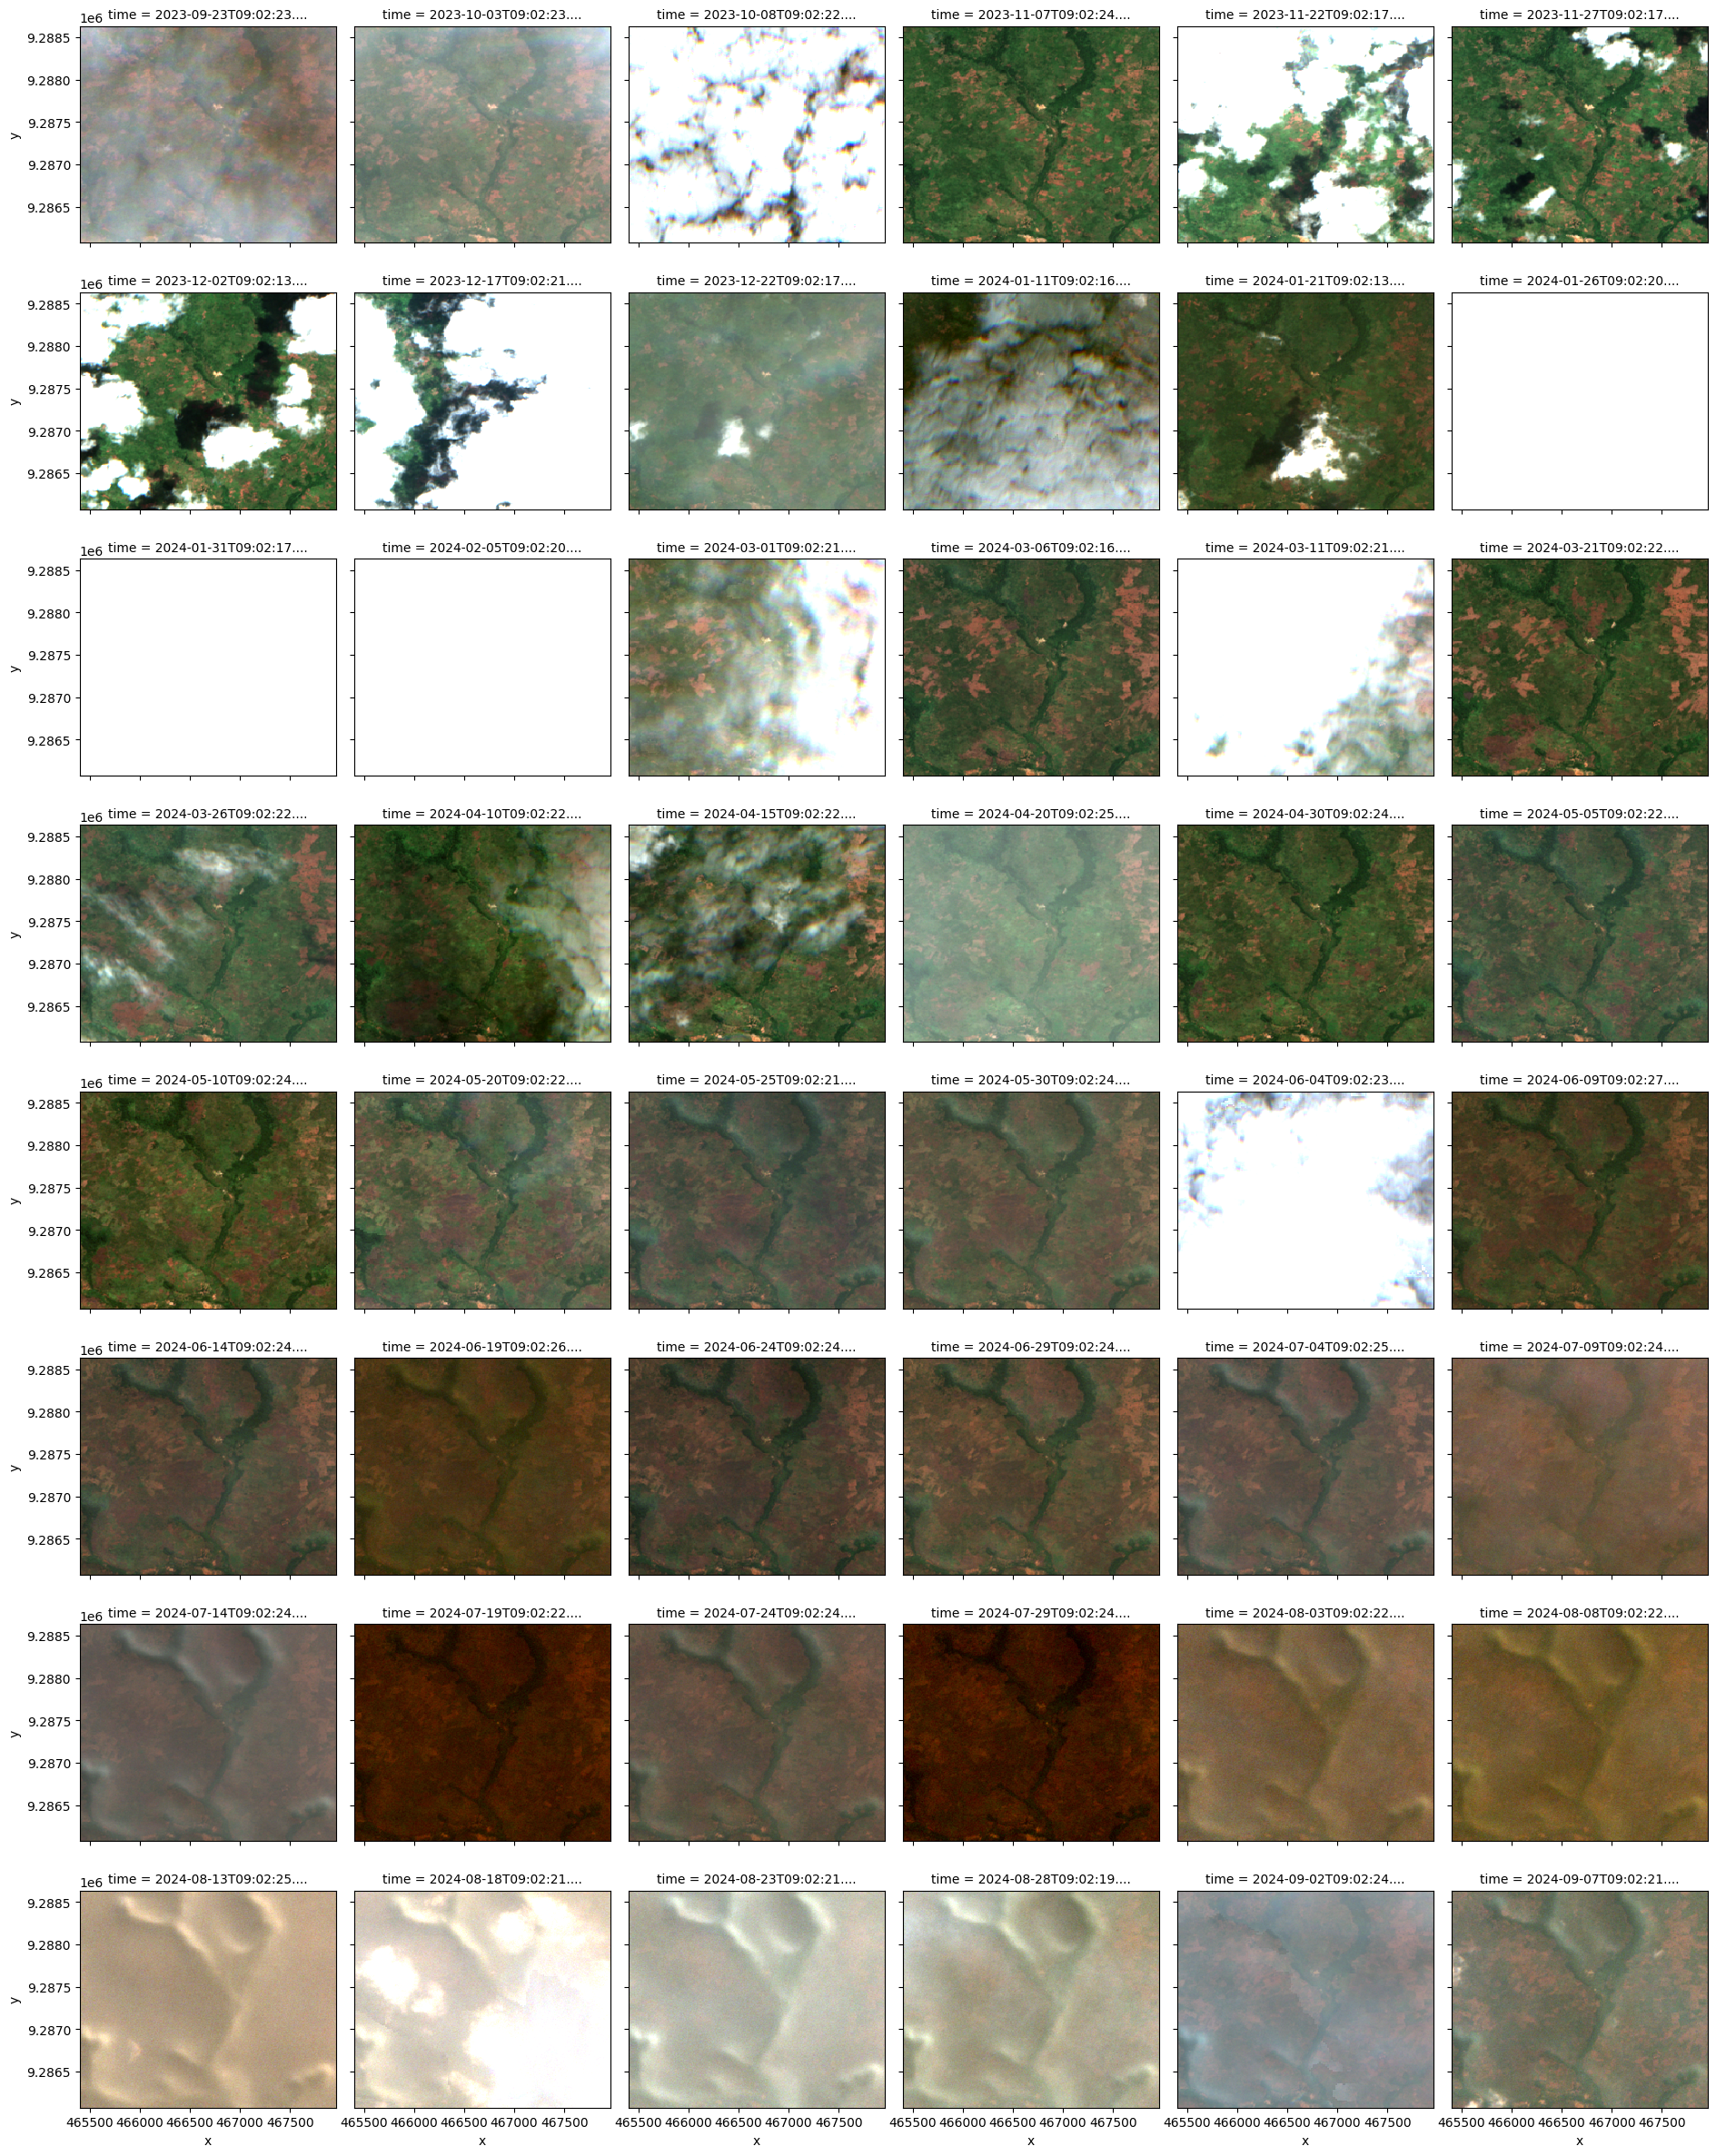

In [29]:
stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

## Estimate cloud cover for each timestep

First; what even is a cloud? Find a good ballpark value for the brightness of a cloud, recalling that this is int64 data, and the histogram will vary widely.

In [53]:
# Function to calculate the maximum value in each band for a given image tile, 
# For the purpose of eyeballing a good "cloud" value
def calculate_band_max(image_data):
    # Get the red, green, and blue bands
    red = image_data.sel(band="red").values
    green = image_data.sel(band="green").values
    blue = image_data.sel(band="blue").values
    
    # Calculate the maximum value in each band
    max_red = np.max(red)
    max_green = np.max(green)
    max_blue = np.max(blue)
    
    return max_red, max_green, max_blue

# Iterate over the stack along the 'time' dimension
for i in range(len(stack["time"])):
    # Select the i-th image tile
    image = stack.isel(time=i)
    
    # Get the time value for the current tile and convert to YYYY-MM-DD format
    time_value = pd.to_datetime(stack["time"].isel(time=i).values).strftime('%Y-%m-%d')
    
    # Calculate max values in each band
    max_red, max_green, max_blue = calculate_band_max(image)
    
    # Print the max values for the current tile
    print(f"Tile at time {time_value} - Max Red: {max_red}, Max Green: {max_green}, Max Blue: {max_blue}")


Tile at time 2023-09-23 - Max Red: 1990, Max Green: 1786, Max Blue: 1762
Tile at time 2023-10-03 - Max Red: 2304, Max Green: 1986, Max Blue: 2100
Tile at time 2023-10-08 - Max Red: 4504, Max Green: 4840, Max Blue: 5416
Tile at time 2023-11-07 - Max Red: 2438, Max Green: 1918, Max Blue: 1374
Tile at time 2023-11-22 - Max Red: 10128, Max Green: 10336, Max Blue: 10928
Tile at time 2023-11-27 - Max Red: 4928, Max Green: 5156, Max Blue: 5480
Tile at time 2023-12-02 - Max Red: 7928, Max Green: 8264, Max Blue: 8888
Tile at time 2023-12-17 - Max Red: 13856, Max Green: 14408, Max Blue: 15480
Tile at time 2023-12-22 - Max Red: 3006, Max Green: 3144, Max Blue: 3228
Tile at time 2024-01-11 - Max Red: 1940, Max Green: 2030, Max Blue: 2068
Tile at time 2024-01-21 - Max Red: 5640, Max Green: 5488, Max Blue: 5516
Tile at time 2024-01-26 - Max Red: 18312, Max Green: 20120, Max Blue: 23032
Tile at time 2024-01-31 - Max Red: 19528, Max Green: 21048, Max Blue: 23288
Tile at time 2024-02-05 - Max Red: 7880

We can visually see that the capture at 2024-01-31 is 100% cloudy, and that the max values are all pushing 20000. A more subtly clouded capture is from 2023-09-23, and that seems to have max values in the 1500+ range. Let's pin this to 1500 and see what we get.

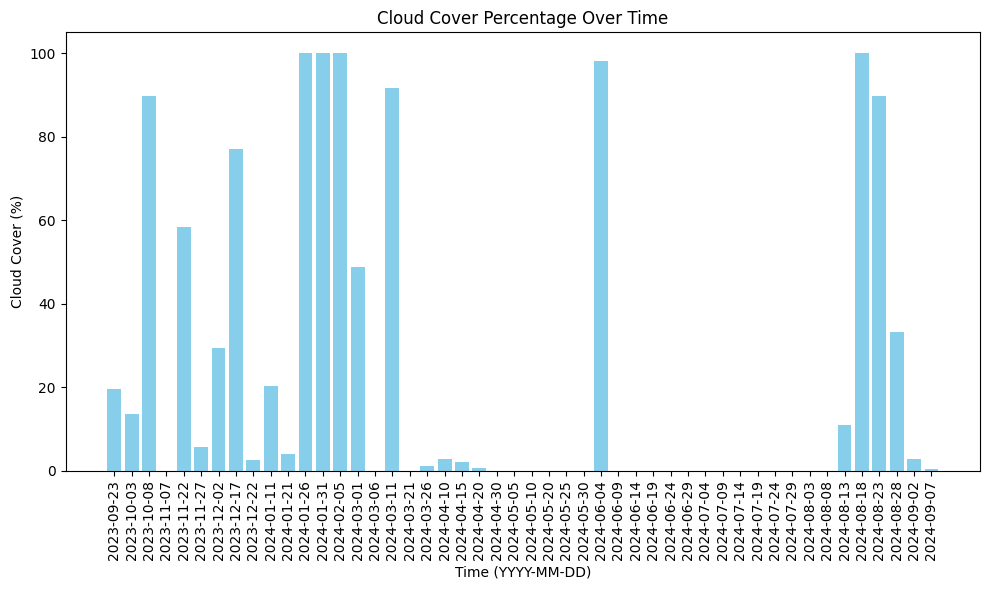

In [54]:
# Function to calculate the percentage of nearly white pixels for each tile
def calculate_cloud_cover(image_data, threshold=1200):
    # Get the red, green, and blue bands
    red = image_data.sel(band="red").values
    green = image_data.sel(band="green").values
    blue = image_data.sel(band="blue").values
    
    # Create a boolean mask for pixels that are white or nearly white
    white_mask = (red >= threshold) & (green >= threshold) & (blue >= threshold)
    
    # Calculate the total number of pixels using the size of one band (e.g., red)
    total_pixels = red.size
    
    # Count the number of white pixels (True values in the white_mask)
    white_pixels = np.count_nonzero(white_mask)
    
    # Calculate the percentage of white pixels (cloud cover)
    percentage_white = (white_pixels / total_pixels) * 100
    
    return percentage_white

# Initialize lists to store time values and cloud cover percentages
time_values = []
cloud_cover_percentages = []

# Iterate over the stack along the 'time' dimension
for i in range(len(stack["time"])):
    # Select the i-th image tile
    image = stack.isel(time=i)
    
    # Get the time value for the current tile and convert to YYYY-MM-DD format
    time_value = pd.to_datetime(stack["time"].isel(time=i).values).strftime('%Y-%m-%d')
    
    # Calculate cloud cover
    cloud_cover = calculate_cloud_cover(image)
    
    # Store the time and cloud cover values
    time_values.append(time_value)
    cloud_cover_percentages.append(cloud_cover)

# Plotting the cloud cover percentage over time
plt.figure(figsize=(10, 6))
plt.bar(time_values, cloud_cover_percentages, color='skyblue')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Time (YYYY-MM-DD)')
plt.ylabel('Cloud Cover (%)')
plt.title('Cloud Cover Percentage Over Time')
plt.tight_layout()

# Show the plot
plt.show()
